In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina' # much faster than svg when generating lots of points
import statsmodels.formula.api as smf
import statsmodels.stats.anova as sa
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm
# set print precision
np.set_printoptions(precision=5, suppress=True)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [39]:
# load train data to build model
df = pd.read_csv('data/train.csv')
del df['type']
df.head()

,category,rating,reviews,installs,price,content_rating,app_size,last_updated_encoded
0,Tools,4.30000,1.09861,4.60517,2.99000,Everyone,4.60000,2923
1,Lifestyle,4.40000,6.02102,9.21034,2.99000,Everyone 10+,22.00000,2372
2,Lifestyle,4.50000,5.82600,8.51719,2.99000,Everyone,10.00000,3054
3,Lifestyle,4.80000,2.77259,6.21461,1.99000,Everyone,8.90000,2685
4,Lifestyle,4.50000,7.59337,9.21034,3.99000,Everyone 10+,28.00000,3120


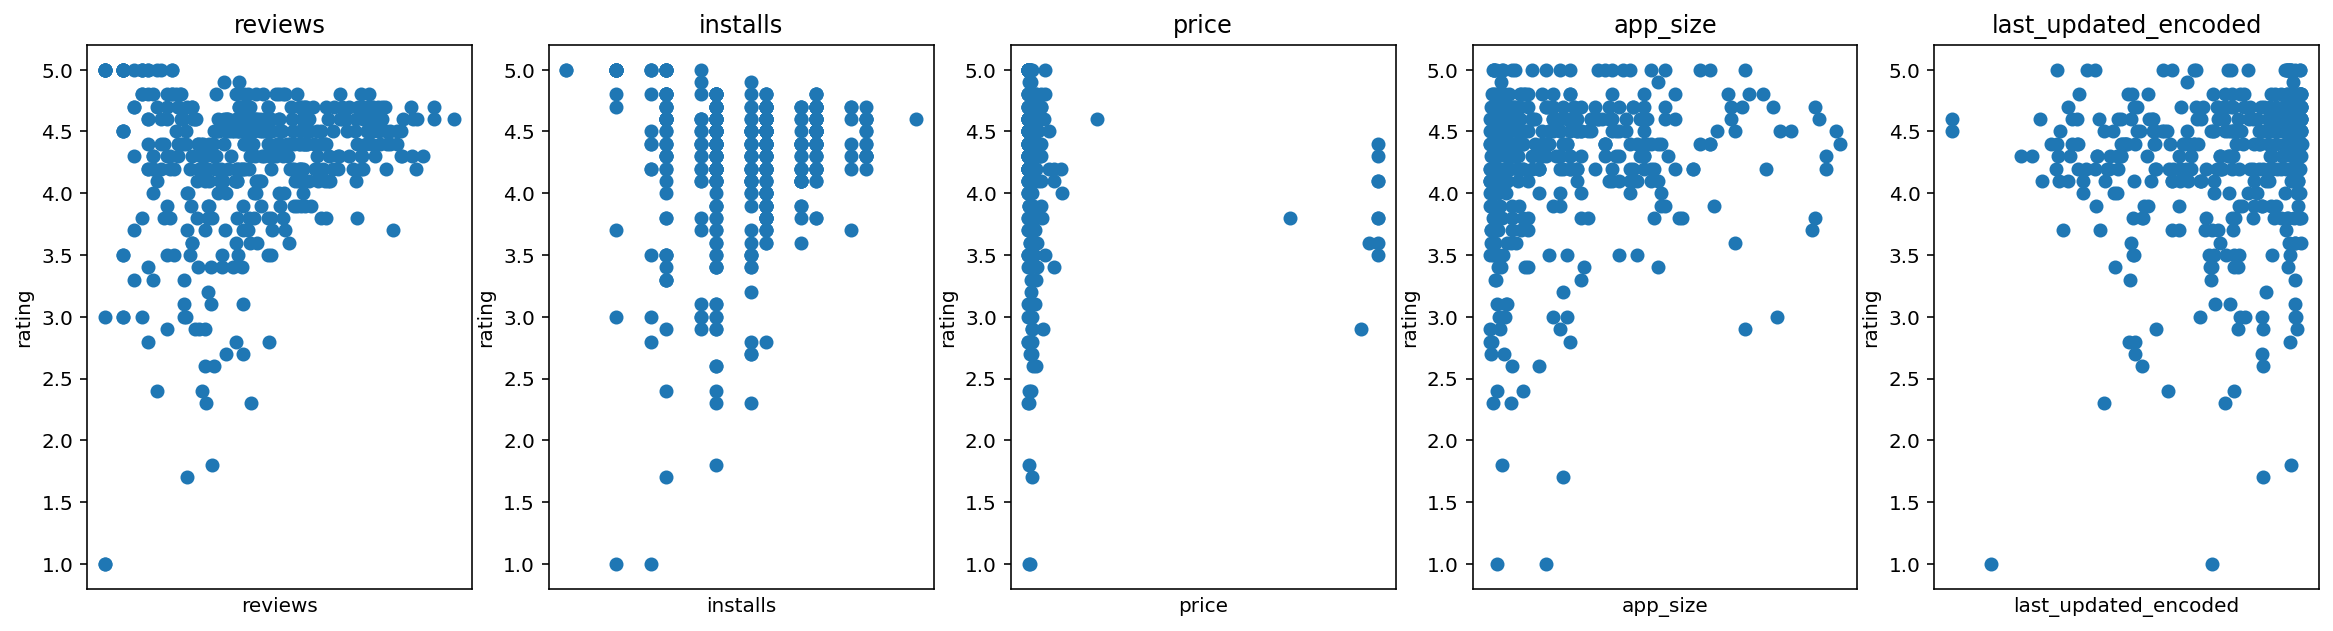

In [40]:
#scatter plots for numerical variables

plt.figure(figsize=(20, 5))
numerical_variables = ['reviews','installs','price','app_size','last_updated_encoded']

for i, col in enumerate(numerical_variables):
    plt.subplot(1, 5, i+1)
    x = df[col]
    y = df['rating']
    plt.plot(x, y, 'o')
    plt.xticks([])
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('rating')

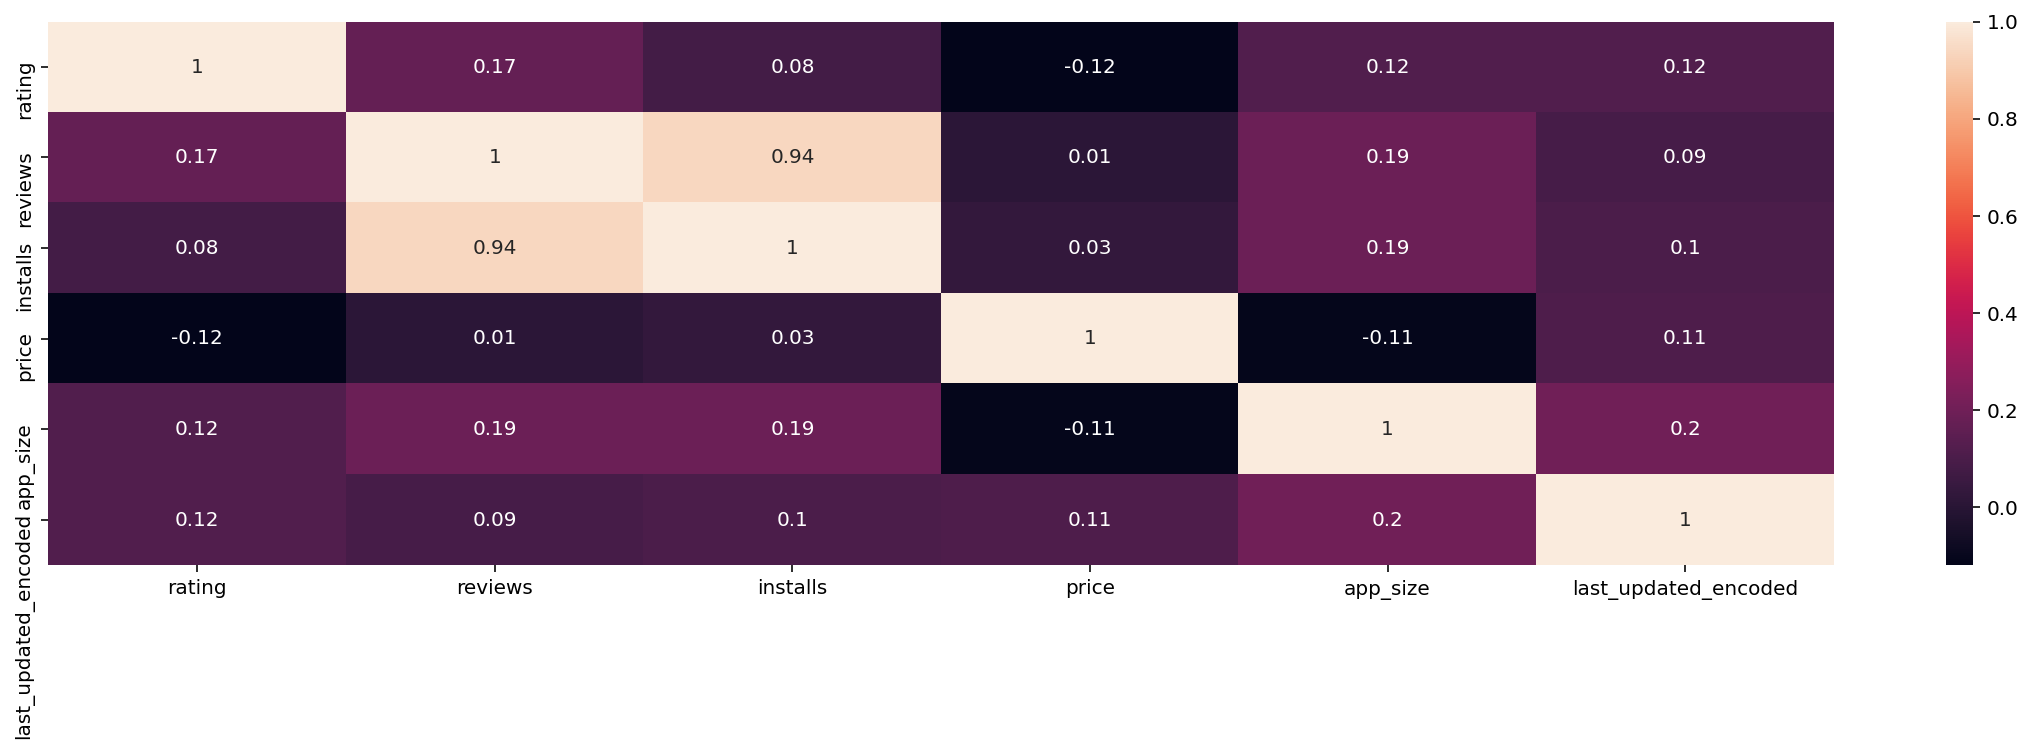

In [41]:
#checking multicollinearity.From heat map seems like reviews and installs are correlated.
import seaborn as sns
correlation_matrix = df.corr().round(2)
plt.figure(figsize = (20,5))
sns.heatmap(data=correlation_matrix, annot=True)

In [42]:
#the vif scores are checked here
from patsy import dmatrices
ystr = 'rating'
xstr = '+'.join([col for col in df.columns if col != ystr])
y, X = dmatrices(f'{ystr}~{xstr}', data=df, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

    VIF Factor                        features
0     50.40247                       Intercept
1      3.81555       category[T.Entertainment]
2      4.53785           category[T.Lifestyle]
3      1.63185              category[T.Social]
4      4.65304               category[T.Tools]
5      1.08478  content_rating[T.Everyone 10+]
6      1.03206    content_rating[T.Mature 17+]
7      1.17389          content_rating[T.Teen]
8      8.61852                         reviews
9      8.44288                        installs
10     1.09767                           price
11     1.26839                        app_size
12     1.07253            last_updated_encoded


In [43]:
ystr = 'rating'
xstr = '+'.join([col for col in df.columns if col != ystr])
model = smf.ols(f'{ystr}~{xstr}', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     5.939
Date:                Fri, 27 Nov 2020   Prob (F-statistic):           1.38e-09
Time:                        17:43:49   Log-Likelihood:                -348.64
No. Observations:                 432   AIC:                             723.3
Df Residuals:                     419   BIC:                             776.2
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

#### category has only one(tools) which has p value less than 0.05. So, it is still significant.
#### content-rating not significant
#### app-size not significant


In [44]:
# The partial and sequential anova to re-confirm the t- test values
partial = sm.stats.anova_lm(model, typ=2)
seq = sm.stats.anova_lm(model, typ=1)

print('~~~~~~~ Partial ANOVA ~~~~~~~')
print(partial)

print('\n~~~~~~~ Sequential ANOVA ~~~~~~~')
print(seq)

~~~~~~~ Partial ANOVA ~~~~~~~
                        sum_sq        df        F  PR(>F)
category               3.82650   4.00000  3.15471 0.01423
content_rating         0.66833   3.00000  0.73466 0.53179
reviews               11.23535   1.00000 37.05139 0.00000
installs               8.48538   1.00000 27.98266 0.00000
price                  1.41480   1.00000  4.66564 0.03134
app_size               0.33140   1.00000  1.09289 0.29643
last_updated_encoded   2.04747   1.00000  6.75205 0.00969
Residual             127.05625 419.00000      nan     nan

~~~~~~~ Sequential ANOVA ~~~~~~~
                            df    sum_sq  mean_sq        F  PR(>F)
category               4.00000   3.74014  0.93504  3.08351 0.01603
content_rating         3.00000   1.48658  0.49553  1.63412 0.18082
reviews                1.00000   3.70533  3.70533 12.21927 0.00052
installs               1.00000   8.54249  8.54249 28.17102 0.00000
price                  1.00000   1.30220  1.30220  4.29434 0.03885
app_size    

#### The partial anova gives same inferences as t-test.But need to check the sequential anova in different combinations of predictors

In [45]:
# removed app_size
ystr = 'rating'
rem = 'app_size'
xstr = '+'.join([col for col in df.columns if col != ystr and col != rem])
model1 = smf.ols(f'{ystr}~{xstr}', data=df).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     6.378
Date:                Fri, 27 Nov 2020   Prob (F-statistic):           8.44e-10
Time:                        17:46:13   Log-Likelihood:                -349.20
No. Observations:                 432   AIC:                             722.4
Df Residuals:                     420   BIC:                             771.2
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [46]:
seq1 = sm.stats.anova_lm(model1, typ=1)  
print(seq1)

                            df    sum_sq  mean_sq        F  PR(>F)
category               4.00000   3.74014  0.93504  3.08283 0.01604
content_rating         3.00000   1.48658  0.49553  1.63376 0.18090
reviews                1.00000   3.70533  3.70533 12.21657 0.00052
installs               1.00000   8.54249  8.54249 28.16479 0.00000
price                  1.00000   1.30220  1.30220  4.29339 0.03887
last_updated_encoded   1.00000   2.50226  2.50226  8.25001 0.00428
Residual             420.00000 127.38766  0.30330      nan     nan


In [47]:
#removed content_rating
ystr = 'rating'
rem = 'content_rating'
xstr = '+'.join([col for col in df.columns if col != ystr and col != rem])
model2 = smf.ols(f'{ystr}~{xstr}', data=df).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     7.688
Date:                Fri, 27 Nov 2020   Prob (F-statistic):           1.73e-10
Time:                        17:47:57   Log-Likelihood:                -349.77
No. Observations:                 432   AIC:                             719.5
Df Residuals:                     422   BIC:                             760.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [48]:
seq2 = sm.stats.anova_lm(model2, typ=1) 
print(seq2)

                            df    sum_sq  mean_sq        F  PR(>F)
category               4.00000   3.74014  0.93504  3.08934 0.01587
reviews                1.00000   4.18581  4.18581 13.82986 0.00023
installs               1.00000   8.66063  8.66063 28.61460 0.00000
price                  1.00000   1.35359  1.35359  4.47223 0.03504
app_size               1.00000   1.02089  1.02089  3.37301 0.06698
last_updated_encoded   1.00000   1.98102  1.98102  6.54524 0.01086
Residual             422.00000 127.72458  0.30266      nan     nan


In [49]:
#sequence with content_rating and app_size first
model3 = smf.ols('rating~content_rating+category+app_size+reviews+price+installs+last_updated_encoded' , data=df).fit()
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     5.939
Date:                Fri, 27 Nov 2020   Prob (F-statistic):           1.38e-09
Time:                        17:49:54   Log-Likelihood:                -348.64
No. Observations:                 432   AIC:                             723.3
Df Residuals:                     419   BIC:                             776.2
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [50]:
seq3 = sm.stats.anova_lm(model3, typ=1)  
print(seq3)

                            df    sum_sq  mean_sq        F  PR(>F)
content_rating         3.00000   1.59453  0.53151  1.75278 0.15559
category               4.00000   3.63219  0.90805  2.99452 0.01860
app_size               1.00000   1.00315  1.00315  3.30814 0.06965
reviews                1.00000   3.36416  3.36416 11.09418 0.00094
price                  1.00000   1.54809  1.54809  5.10523 0.02437
installs               1.00000   8.42082  8.42082 27.76977 0.00000
last_updated_encoded   1.00000   2.04747  2.04747  6.75205 0.00969
Residual             419.00000 127.05625  0.30324      nan     nan


In [51]:
# remove content_rating but include app_size
model4 = smf.ols('rating~category+app_size+reviews+price+installs+last_updated_encoded' , data=df).fit()
print(model4.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     7.688
Date:                Fri, 27 Nov 2020   Prob (F-statistic):           1.73e-10
Time:                        17:51:11   Log-Likelihood:                -349.77
No. Observations:                 432   AIC:                             719.5
Df Residuals:                     422   BIC:                             760.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [52]:
seq4 = sm.stats.anova_lm(model4, typ=1)  
print(seq4)

                            df    sum_sq  mean_sq        F  PR(>F)
category               4.00000   3.74014  0.93504  3.08934 0.01587
app_size               1.00000   1.46711  1.46711  4.84730 0.02823
reviews                1.00000   3.65708  3.65708 12.08293 0.00056
price                  1.00000   1.51872  1.51872  5.01784 0.02561
installs               1.00000   8.57802  8.57802 28.34164 0.00000
last_updated_encoded   1.00000   1.98102  1.98102  6.54524 0.01086
Residual             422.00000 127.72458  0.30266      nan     nan


#### app_size, when put at the top of the sequence has become significant, which means that app_size is significant to rating only when category is the only predictor in the model.
#### But no change with content_rating even after putting it at the first
#### So, maybe remove only content-rating.

In [53]:
model5 = smf.ols('rating~category+reviews+price+installs+last_updated_encoded+app_size' , data=df).fit()
print(model5.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     7.688
Date:                Fri, 27 Nov 2020   Prob (F-statistic):           1.73e-10
Time:                        17:57:59   Log-Likelihood:                -349.77
No. Observations:                 432   AIC:                             719.5
Df Residuals:                     422   BIC:                             760.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [54]:
seq5 = sm.stats.anova_lm(model5, typ=1)  
print(seq5)

                            df    sum_sq  mean_sq        F  PR(>F)
category               4.00000   3.74014  0.93504  3.08934 0.01587
reviews                1.00000   4.18581  4.18581 13.82986 0.00023
price                  1.00000   1.81389  1.81389  5.99307 0.01477
installs               1.00000   8.20033  8.20033 27.09376 0.00000
last_updated_encoded   1.00000   2.49041  2.49041  8.22827 0.00433
app_size               1.00000   0.51150  0.51150  1.68999 0.19431
Residual             422.00000 127.72458  0.30266      nan     nan


#### app-size is not significant given other predictors
#### final predictors- category,reviews,price,installs,last_updated_encoded